In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Standard library imports
import os
import shutil
import asyncio

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from affine import Affine

from matplotlib.colors import LogNorm
import requests
import urllib3
import pydantic
import geojson
import contextily as ctx
from scipy import ndimage
from scipy.ndimage import binary_dilation

# Geospatial imports
from osgeo import gdal
import pandas as pd
import geopandas as gpd
import osmnx
from shapely.geometry import box
from shapely.geometry import mapping
import rasterio
from rasterio.plot import show
from rasterio import features
from rasterio.features import rasterize
from pysheds.grid import Grid
from rasterio.mask import mask
import pyflwdir


# Local/custom module imports
import hoydedata_api
from NVE_FKB_Api import get_sql_db
from resampletif import resample_tif_by_resolution
from Computeflow import compute_flow_acc
from Computeflow import compute_rivers

In [3]:
# ## DEFINE VARIABLES    # DEFAULT FOR 10 M DATA
# # IN-SCRIPT-VALUES
# vassdrag_nr = "122.Z"   # Nummer av vassdraget fra fkb-databasen.
# target_res = 10         # Ønsket oppløsning i meter for DTM og avledede produkter.
# burn_depth=0            # Elv innbrenningsdybde, originalt 50m men dette scriptet fungerer godt med 0m
# buffer=1                # buffer ~1 pixel på hver side, juster for å teste senere.
# all_touched=True        # ENDRE IKKE - alle celler som berøres av elvelinjen vil bli brent.
# close_iter=1            # ENDRE IKKE - Closing kan hjelpe til med å fylle små hull i elvelinjene.
# dilate_iter=1           # ENDRE IKKE - Dilation kan hjelpe til med å sikre at elvelinjene blir fullt fanget.
# min_area = 5            # Minimum areal km^2 for sub-nedbørfelt.
# min_sto = 5             # Minimum Strahler orden for å definere elvelinjer.
# b = 0.5                 # Justerbar konstant for flomplanskartet, 0.4 gir et kart som ser ut som 1:200m f-akt.
# upa_min = 1             # Minimum oppeareal for flomplanskartet i km^2.

In [ ]:
## DEFINE VARIABLES
# IN-SCRIPT-VALUES
vassdrag_nr = "122.Z"   # Nummer av vassdraget fra fkb-databasen.
target_res = 5         # Ønsket oppløsning i meter for DTM og avledede produkter.
burn_depth=0            # Elv innbrenningsdybde, originalt 50m men dette scriptet fungerer godt med 0m
buffer=1                # buffer ~1 pixel på hver side, juster for å teste senere. # FOR 1 M DATA, BUFFER 1 PX,
all_touched=True        # ENDRE IKKE - alle celler som berøres av elvelinjen vil bli brent.
close_iter=1            # ENDRE IKKE - Closing kan hjelpe til med å fylle små hull i elvelinjene.
dilate_iter=1           # ENDRE IKKE - Dilation kan hjelpe til med å sikre at elvelinjene blir fullt fanget.
min_area = 5            # Minimum areal km^2 for sub-nedbørfelt.
min_sto = 5             # Minimum Strahler orden for å definere elvelinjer.
b = 0.5                 # Justerbar konstant for flomplanskartet, 0.4 gir et kart som ser ut som 1:200m f-akt.
upa_min = 1             # Minimum oppeareal for flomplanskartet i km^2.

In [5]:
# FKBvann data - Nedbørfelt
# For å laste ned alle vassdragene
FKB_Nedborfelt = get_sql_db(bounds=None, dbname='innsyn', table='vann.Nedborfelt_NFeltF',  server='gis-sql04')
#FKB_Nedborfelt.head(2)

In [6]:
## GETTING NBF BOUNDARY FROM FKB DATA
def get_nbf_bounds(fkb_nedborfelt: gpd.GeoDataFrame, vassdrag_nr: str) -> tuple:
    """
    Get the exact bounding box coordinates for a specific drainage basin (nedbørfelt)
    based on its vassdragNr and return the basin polygon.
    
    Args:
        fkb_nedborfelt: GeoDataFrame containing watershed data
        vassdrag_nr: The vassdragNr identifier for the desired drainage basin
        
    Returns:
        tuple: ((xmin, ymin, xmax, ymax), basin_gdf) - bounds and the basin GeoDataFrame
    """
    # Filter the dataset to get only the specified drainage basin
    basin = fkb_nedborfelt[fkb_nedborfelt['vassdragNr'] == vassdrag_nr]
    
    if basin.empty:
        raise ValueError(f"No drainage basin found with vassdragNr: {vassdrag_nr}")
    
    # Get the basin name
    basin_name = basin.iloc[0]['navnNedbf'] if 'navnNedbf' in basin.columns else "Unknown"
    
    # Get the exact bounds of the filtered basin
    xmin, ymin, xmax, ymax = basin.total_bounds
    
    print(f"Bounds for vassdragNr {vassdrag_nr} ({basin_name}):")
    print(f"xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
    
    return (xmin, ymin, xmax, ymax), basin

Bounds for vassdragNr 122.Z (Gaula):
xmin: 240385.70529999956, ymin: 6952336.710000001, xmax: 335636.9400000004, ymax: 7036643.987300001


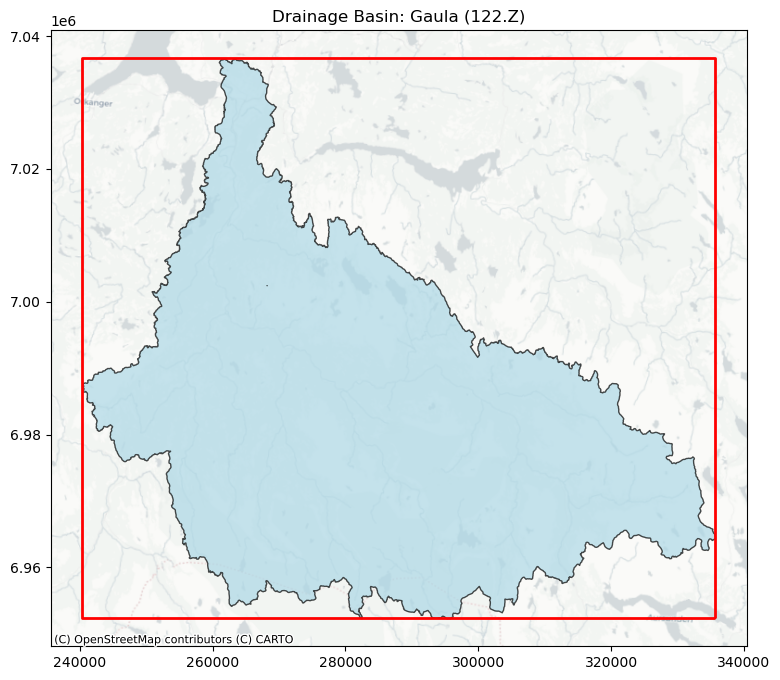

In [7]:
# Define vassdrag_nr for import. Can be found in FKB_Nedbørfelt dataset.
vassdrag_bounds, vassdrag_basin_gdf = get_nbf_bounds(FKB_Nedborfelt, vassdrag_nr)

# Create a bounding box for visualization
vassdrag_bbox = box(*vassdrag_bounds)
vassdrag_bbox_gdf = gpd.GeoDataFrame(geometry=[vassdrag_bbox], crs=FKB_Nedborfelt.crs)

# Visualization of the selected basin and its bounding box
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the specific basin polygon
vassdrag_basin_gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7)

# Plot the bounding box
vassdrag_bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=2)

# Get the basin name for the title
vassdrag_basin_name = vassdrag_basin_gdf.iloc[0]['navnNedbf'] if 'navnNedbf' in vassdrag_basin_gdf.columns else "Unknown"

# Add title and other elements
plt.title(f"Drainage Basin: {vassdrag_basin_name} ({vassdrag_nr})")

# Optional: Add basemap for context
try:
    ctx.add_basemap(ax, crs=FKB_Nedborfelt.crs.to_string(),
                    source=ctx.providers.CartoDB.Positron)
except:
    pass  # Skip if contextily is not available or fails

#DisplayBounds
dxmin = vassdrag_bounds[0]-0.001e6
dymin = vassdrag_bounds[1]-0.001e6
dxmax = vassdrag_bounds[2]+0.001e6
dymax = vassdrag_bounds[3]+0.001e6
dbounds = dxmin, dymin, dxmax, dymax

# Set the extent to the bounds
# ax.set_xlim(vassdrag_bounds[0], vassdrag_bounds[2])
# ax.set_ylim(vassdrag_bounds[1], vassdrag_bounds[3])

# plt.tight_layout()
# plt.show()

In [8]:
# FKBvann data - ELVIS
# Grab lake/river data with rough clipping to boundary box of vassdrag
FKB_ELVIS = get_sql_db(bounds=vassdrag_bounds, dbname='innsyn', table='vann.ElvenettL',  server='gis-sql04')
FKB_INNSJO = get_sql_db(bounds=vassdrag_bounds, dbname='innsyn', table='vann.N50_InnsjoFlate', server='gis-sql04')

## Clip lake/river data by border of vassdrag
ELVIS_lim_vassdrag = gpd.clip(FKB_ELVIS, vassdrag_basin_gdf)
INNSJO_lim_vassdrag = gpd.clip(FKB_INNSJO, vassdrag_basin_gdf)

# Let's see all unique values in the "objtype" columns
# Only use if unsure - several areas have odd values that
# are due to manual metadata processing in the FKB data.
unique_elv = ELVIS_lim_vassdrag["objektType"].unique()
#print("Unique values in 'objektType' column:")
#print(unique_elv)
unique_innsjo = INNSJO_lim_vassdrag["objektType"].unique()
#print("Unique values in 'objektType' column:")
#print(unique_innsjo)

C:\Users\thob\AppData\Local\Temp\5\ipykernel_16304\1439614042.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper right')
C:\Users\thob\AppData\Local\Temp\5\ipykernel_16304\1439614042.py:41: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax2.legend(loc='upper right')


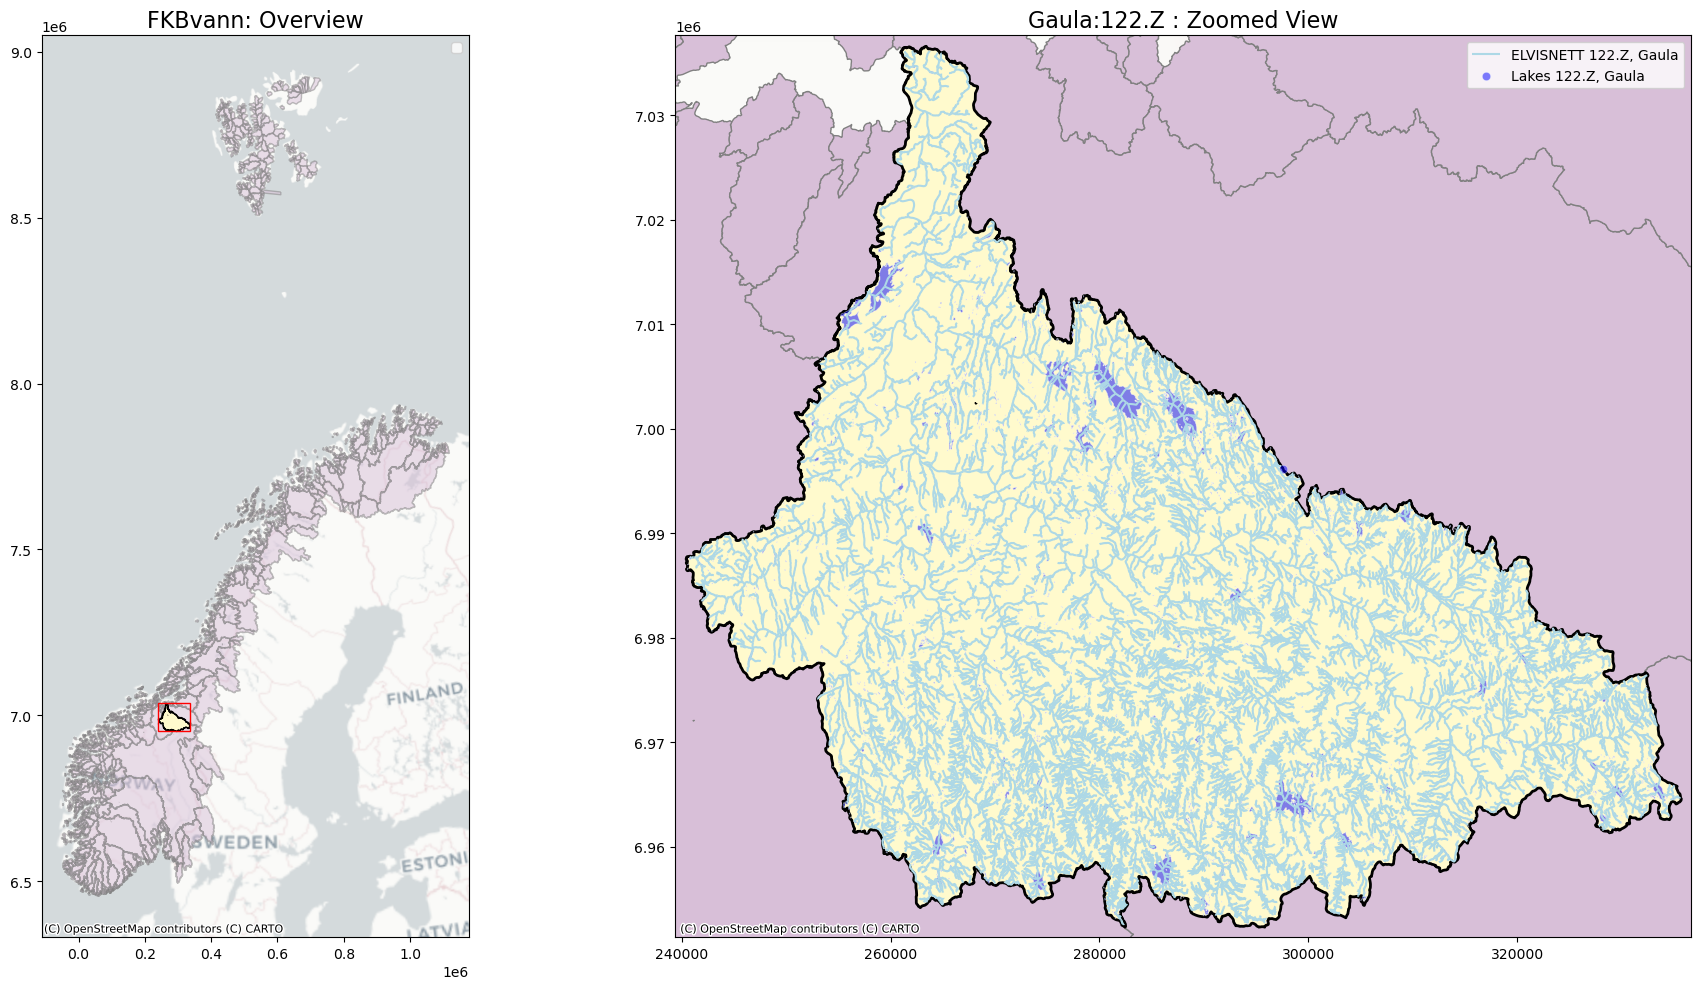

In [9]:
## Plot FKB data on basemap
# This can be removed to save on processing time if needed.
# PREFER TO COMMENT OUT (CTRL+K+C in Visual Studio Code)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# First subplot - Overview
# Plot the water features with different colors and transparency
#ELVIS_lim_vassdrag.plot(ax=ax1, color='blue', label=f'ELVISNETT {vassdrag_nr}, {vassdrag_basin_name}')
FKB_Nedborfelt.plot(ax=ax1, color='thistle', edgecolor="grey", linewidth=1, alpha=0.5)
vassdrag_basin_gdf.plot(ax=ax1, color='lemonchiffon', edgecolor='black', linewidth=1)

# Convert the bounding box to Web Mercator for basemap
bbox_webmerc = vassdrag_bbox_gdf.to_crs(epsg=3857)

# Add the basemap using contextily (greyscale)
ctx.add_basemap(ax1, crs=FKB_Nedborfelt.crs.to_string(),
                source=ctx.providers.CartoDB.Positron)

# Add title and legend for first subplot
ax1.set_title('FKBvann: Overview', fontsize=16)
ax1.legend(loc='upper right')

# Second subplot - Zoomed in view
ELVIS_lim_vassdrag.plot(ax=ax2, color='lightblue', label=f'ELVISNETT {vassdrag_nr}, {vassdrag_basin_name}')
FKB_Nedborfelt.plot(ax=ax2, color='thistle', edgecolor="grey", linewidth=1)
vassdrag_basin_gdf.plot(ax=ax2, color='lemonchiffon', edgecolor='black', linewidth=2)
INNSJO_lim_vassdrag.plot(ax=ax2, color='blue', edgecolor='aliceblue', linewidth=0.5, alpha=0.5, label=f'Lakes {vassdrag_nr}, {vassdrag_basin_name}')

# Add the basemap to the zoomed view
ctx.add_basemap(ax2, crs=FKB_Nedborfelt.crs.to_string(),
                source=ctx.providers.CartoDB.Positron)

# Set the extent of the zoomed plot to our area of interest
ax2.set_xlim(dxmin, dxmax)
ax2.set_ylim(dymin, dymax)

# Add title and legend for second subplot
ax2.set_title(f'{vassdrag_basin_name}:{vassdrag_nr} : Zoomed View', fontsize=16)
ax2.legend(loc='upper right')

# Draw a rectangle on the overview plot showing the zoomed area
from matplotlib.patches import Rectangle
rect = Rectangle((dxmin, dymin), dxmax-dxmin, dymax-dymin, 
                 linewidth=1, edgecolor='red', facecolor='none')
ax1.add_patch(rect)

plt.tight_layout()
plt.show()

In [ ]:
# # Download and merge 1 m dataset for elevation
# # Use this if need to download a new vassdrag DTM
# # DISABLE OTHERWISE, THIS IS A TIME-CONSUMING STEP

# # Download and automerge
bounds = vassdrag_bounds
bounds = (vassdrag_bounds[0], vassdrag_bounds[1], vassdrag_bounds[2], vassdrag_bounds[3])
# await hoydedata_api.download_elevation_model(
# bounds=bounds,
# resolution_meters=1, 
# output_path=f"../RAW/NBF_{vassdrag_basin_name}.tif"

In [11]:
# # If the DTM needs rescaling, use this
RAW_DTM = f"../RAW/NBF_{vassdrag_basin_name}.tif"
RS_DIR = "../OUT/"
RS_DTM = f"{RS_DIR}VD_{vassdrag_basin_name}_R{int(target_res)}m.tif"

if os.path.exists(RS_DTM):
    print(f"RS_DTM already exists at {RS_DTM}, skipping move/resample.")
else:
    if target_res == 1:
        # move and rename RAW data
        print("Target resolution is 1m, moving RAW data without resampling...")
        shutil.move(RAW_DTM, RS_DTM)
        print(f"RAW data moved from RAW to: {RS_DTM}")
    else:
        print("Resampling DTM...")
        resample_tif_by_resolution(RAW_DTM, RS_DTM, target_res)
        print(f"finished and saved to: {RS_DTM}")

RS_DTM already exists at ../OUT/VD_Gaula_R1m.tif, skipping move/resample.


In [12]:
# Define DTM path for import
# Maintain inclusion of profile, crs and transform for a fixed reference point.

# Read in DTM from RS_DTM
with rasterio.open(RS_DTM) as src:
    # Read in dtm to numpy array
    dtm = src.read(1)
    dtm_profile = src.profile
    dtm_crs = src.crs
    dtm_transform = src.transform

## Clip dtm to bounds for all future data, not extent for catchment
# Clip DTM to exact geom of vassdrag, setting outside values as nodata
# Prep variable dtm_masked for later usage.
shapes = ((geom, 1) for geom in vassdrag_basin_gdf.geometry)
mask = rasterize(
    shapes,
    out_shape=dtm.shape,
    transform=dtm_transform,
    fill=0,
    dtype='uint8'
)

dtm_masked = np.where(mask ==1, dtm, np.nan)

In [13]:
# Robust burn - uses a buffer to ensure river lines are fully captured
# Uses additional components to fully clean up the data
def robust_burn(dtm, transform, river_gdf, burn_depth=5.0, buffer_m=None, all_touched=True,
                close_iter=1, dilate_iter=1):
    px = abs(transform.a)
    if buffer_m is None:
        buffer_m = max(px * 1.0, px * 1.5)  # buffer at least ~1 pixel
    buf = river_gdf.geometry.buffer(buffer_m)
    shapes = ((mapping(g), 1) for g in buf)
    mask = rasterize(shapes, out_shape=dtm.shape, transform=transform, all_touched=all_touched, dtype=np.uint8)
    if close_iter > 0:
        mask = ndimage.binary_closing(mask, iterations=close_iter)
    if dilate_iter > 0:
        mask = ndimage.binary_dilation(mask, iterations=dilate_iter)
    burned = np.minimum(dtm, dtm - burn_depth * mask)
    return burned, mask


In [14]:
# OPTIONAL: ADD CELL FOR FILLING SINKS AND DEPRESSIONS - PYFLWDIR APPEARS TO NOT REQUIRE THIS.
# ALSO INCLUSION OF "HYDROENFORCEMENT"

In [15]:
## Define variables for burning in of rivers
# Burning can be edited on a catchment-by-catchment basis, if issues arise with using 0 m.
# Define save location for burned DTM
# Ensure ELVIS_lim_vassdrag and vassdrag_basin_gdf are in the same CRS as the DTM
# It would be difficult for this not to be the case, but good to have a safeguard.
if ELVIS_lim_vassdrag.crs != dtm_crs:
    rivers_proj = ELVIS_lim_vassdrag.to_crs(dtm_crs)
else:
    rivers_proj = ELVIS_lim_vassdrag

# Optionally mask to basin
if vassdrag_basin_gdf.crs != dtm_crs:
    basin_proj = vassdrag_basin_gdf.to_crs(dtm_crs)
else:
    basin_proj = vassdrag_basin_gdf

# Apply robust burn-in
burned_dtm_rb, river_mask = robust_burn(
    dtm=dtm,
    transform=dtm_transform,
    river_gdf=rivers_proj,
    burn_depth=burn_depth,
    buffer_m=None,   
    all_touched=True,
    close_iter=1,
    dilate_iter=1
)

# Define output location for robust burned DTM
BN_PATH = "../BURNED/"
RBN_DTM = f"{BN_PATH}VD_{vassdrag_basin_name}_RB{burn_depth}_R{int(target_res)}m.tif"

# Export using rasterio, maintaining the original profile but updating the dtype and count for the new data
with rasterio.open(RS_DTM) as src:
    profile = src.profile.copy()
    profile.update(dtype=burned_dtm_rb.dtype, count=1)
    with rasterio.open(RBN_DTM, 'w', **profile) as dst:
        dst.write(burned_dtm_rb, 1)
print(f"Robust burned DTM written to: {RBN_DTM}")

Robust burned DTM written to: ../BURNED/VD_Gaula_RB0_R1m.tif


In [16]:
# Removing vertical noise in the river basin data
# This could be done using filtering, but inverse sinks is more focused.
# Prepare river-and-adjacent-cells inverted DEM for filling
inv_dtm_river = np.full(dtm.shape, -9999, dtype=dtm.dtype)  # nodata everywhere
inv_dtm_river[river_mask.astype(bool)] = -1 * burned_dtm_rb[river_mask.astype(bool)]  # invert at river and adjacent cells (use burned DTM)

# Prep filepaths and save using rasterio
RNET_PATH = '../RNET/'
RNET_FIL = f"{RNET_PATH}VD{vassdrag_basin_name}_INVRIVER_RES{int(target_res)}m.tif"

# Export the river-and-adjacent-cells inverted DEM for filling using rasterio
with rasterio.open(RS_DTM) as src:
    profile = src.profile.copy()
    profile.update(dtype=inv_dtm_river.dtype, count=1, nodata=-9999)
    with rasterio.open(RNET_FIL, 'w', **profile) as dst:
        dst.write(inv_dtm_river, 1)
print(f"River-and-adjacent-cells inverted DEM written to: {RNET_FIL}")

# Use pysheds to fill "sinks" as pits and depressions (which are now high spots in original DEM)
rgrid = Grid.from_raster(str(RNET_FIL), data_name='invdem', nodata=-9999)
invdem = rgrid.read_raster(str(RNET_FIL), data_name='invdem', nodata=-9999)
invdem2 = rgrid.fill_pits(invdem)
invdem_filled_neg = rgrid.fill_depressions(invdem2) # Added fill depressions, some areas still problematic.

# Invert back
river_filled = -1 * invdem_filled_neg

# Only update DEM where river mask is True (river and adjacent cells)
burn_dtm_fix = burned_dtm_rb.copy()
burn_dtm_fix[river_mask.astype(bool)] = river_filled[river_mask.astype(bool)]

# Save the result
BN_FIX = f"{BN_PATH}VD_{vassdrag_basin_name}_RB{burn_depth}_FILL_R{int(target_res)}m.tif"
with rasterio.open(RS_DTM) as src:
    profile = src.profile.copy()
    profile.update(dtype=burn_dtm_fix.dtype, count=1)
    with rasterio.open(BN_FIX, 'w', **profile) as dst:
        dst.write(burn_dtm_fix, 1)
print(f"Inverse sink-filled river DEM written to: {BN_FIX}")

2026-02-25 08:52:21,160 - rasterio._env - WARNING - CPLE_NotSupported in driver GTiff does not support open option DATA_NAME


River-and-adjacent-cells inverted DEM written to: ../RNET/VDGaula_INVRIVER_RES1m.tif


2026-02-25 08:53:00,392 - rasterio._env - WARNING - CPLE_NotSupported in driver GTiff does not support open option DATA_NAME


Inverse sink-filled river DEM written to: ../BURNED/VD_Gaula_RB0_FILL_R1m.tif


In [17]:
# Round the DEM to 2 decimal places before running flow accumulation
# Blockages in the channel in the order of 0.0001 m were causing issues 
# with flow accumulation calculations.
# Cell takes roughly 8-9 minutes for full process on a mid-sized watershed.
burn_dtm_fix_rounded = np.round(burn_dtm_fix, 2) #Number of decimal places to round to.

# Save the rounded DEM
BN_FIX_RND = f"{BN_PATH}VD_{vassdrag_basin_name}_RB{burn_depth}_FILL_RD_R{int(target_res)}m.tif"
with rasterio.open(RS_DTM) as src:
    profile = src.profile.copy()
    profile.update(dtype=burn_dtm_fix_rounded.dtype, count=1)
    with rasterio.open(BN_FIX_RND, 'w', **profile) as dst:
        dst.write(burn_dtm_fix_rounded, 1)
print(f"Rounded inverse sink-filled river DEM written to: {BN_FIX_RND}")

Rounded inverse sink-filled river DEM written to: ../BURNED/VD_Gaula_RB0_FILL_RD_R1m.tif


In [18]:
FACC_PATH = '../FLOWACC/'
FACC_FIL = f"{FACC_PATH}FAC_VD_{vassdrag_basin_name}_RB{burn_depth}_R{int(target_res)}m.tif"
STRAHLER_PATH = '../ELV/'
STRAHLER_FIL = f"{STRAHLER_PATH}SORD{min_sto}_VD_{vassdrag_basin_name}_RB{burn_depth}_R{int(target_res)}m.tif"
ELV_PATH = '../ELV/'
ELV_FIL = f"{ELV_PATH}ELV_VD_{vassdrag_basin_name}_RB{burn_depth}_R{int(target_res)}m.shp"
ELV_FIL_RAS = f"{ELV_PATH}ELV_VD_{vassdrag_basin_name}_RB{burn_depth}_R{int(target_res)}m.tif"
FDIR_PATH = '../FDIR/'
FDIR_FIL = f"{FDIR_PATH}FDIR_VD_{vassdrag_basin_name}_RB{burn_depth}_R{int(target_res)}m.tif"

In [19]:
## Future operations MUST be restricted by area polygon of the vassdrag.
# Clip everything here to basin polygon
# We already have dtm_masked, similar is required for other outputs
# We also already have shapes which defines the clipping extent for the basin.
# Use rasterio to read in burn and FAACC outputs as np arrays

with rasterio.open(BN_FIX_RND) as src2:
    # Read in dtm to numpy array
    fixrd_burndtm = src2.read(1)
    fixrd_burndtm_p = src2.profile
    fixrd_burndtm_c = src2.crs
    fixrd_burndtm_t = src2.transform
                    
# Clip burned, fixed, rounded dtm to exact geom of vassdrag, setting outside values as nodata
mask_fixrd_burndtm = np.where(mask ==1, fixrd_burndtm, np.nan)
print("Burned DTM clipped")

Burned DTM clipped


In [20]:
# Pyflwdir flow direction
# Calculate Flow Direction from DTM using pyflwdir
# Prepare DEM for pyflwdir (set nodata to -9999)
dem = mask_fixrd_burndtm.copy()
dem[np.isnan(dem)] = -9999

# Calculate flow direction (D8)
flw = pyflwdir.from_dem(
    data=dem,
    nodata=-9999,
    transform=dtm_transform,
    latlon=dtm_crs.is_geographic,
    outlets="min",
)

d8_data = flw.to_array(ftype="d8")
d8_data

# Write flow direction to geotiff
with rasterio.open(FDIR_FIL, 'w', **dtm_profile) as dst:
    dst.write(d8_data, 1)
print(f"Flow direction raster written to: {FDIR_FIL}")

Flow direction raster written to: ../FDIR/FDIR_VD_Gaula_RB0_R1m.tif


In [21]:
# Pyflwdir flow accumulation
uparea = flw.upstream_area(unit="km2")

# Write flow accumulation to geotiff
with rasterio.open(FACC_FIL, 'w', **dtm_profile) as dst:
    dst.write(uparea, 1)

In [ ]:
# Pyflwdir stream order
streamorder = flw.stream_order(type="strahler")

# save streamorder as raster
streamorder_raster = streamorder.astype(np.int32)
with rasterio.open(STRAHLER_FIL, 'w', **dtm_profile) as dst:
    dst.write(streamorder_raster, 1)

# Create stream network raster where stream order >= min_sto
stream_raster = np.where(streamorder >= min_sto, 1, 0).astype(np.uint8)

# # Save stream network raster
# with rasterio.open(ELV_FIL_RAS, 'w', **dtm_profile) as dst:
#     dst.write(stream_raster, 1)

In [ ]:
streams = flw.streams(min_sto=min_sto)

# Convert list of features to GeoDataFrame
streams_gdf = gpd.GeoDataFrame.from_features(streams, crs=dtm_crs)
   
# NEED TO FIND A SOLUTION FOR 1 M DATA. THIS BREAKS WITH AN IDXS ERROR.

In [ ]:
# Plot the streams
fig, ax = plt.subplots(figsize=(10, 8))
streams_gdf.plot(ax=ax, color='blue', linewidth=0.5)
plt.show()

In [ ]:
# Save the streams GeoDataFrame to geojson
streams_gdf.to_file(ELV_FIL)
print(f"Streams GeoDataFrame saved to GPKG: {ELV_FIL}")

2026-02-20 12:54:12,210 - pyogrio._io - INFO - Created 19,741 records


Streams GeoDataFrame saved to GPKG: ../ELV/ELV_VD_Gaula_RB0_R10m.geojson


In [ ]:
# convenience method for vectorizing a raster
def vectorize(data, nodata, transform, crs=dtm_crs, name="value"):
    feats_gen = features.shapes(
        data,
        mask=data != nodata,
        transform=transform,
        connectivity=8,
    )
    feats = [
        {"geometry": geom, "properties": {name: val}} for geom, val in list(feats_gen)
    ]

    # parse to geopandas for plotting / writing to file
    gdf = gpd.GeoDataFrame.from_features(feats, crs=crs)
    gdf[name] = gdf[name].astype(data.dtype)
    return gdf

In [ ]:
# Generate minimal area subbasins using pyflwdir
minarea_subbasins, idxs_out = flw.subbasins_area(area_min=min_area)

# Generate subcatchment geodataframe
subcatchment_gdf = vectorize(
    data=minarea_subbasins.astype(np.int32),            # your labeled raster (numpy array)
    nodata=0,                                           # or whatever your nodata value is
    transform=flw.transform,                            # affine transform from your raster
    crs=dtm_crs,                                        # CRS object or string
    name=f"{vassdrag_nr}_subcatch_id"                   # or any property name you want
)

# Save subcatchment_gdf to geopackage file'
#SUBC_PATH = '../SUBCATCHMENTS/'
#SUBC_FIL = f"{SUBC_PATH}SUBC_{vassdrag_basin_name}_RB{burn_depth}_MINAREA{min_area}km2_R{int(target_res)}m.gpkg"
#subcatchment_gdf.to_file("SUBC_5km.gpkg", driver='GPKG')

In [ ]:
# Generate stream_order based basins
stro_subbasins, idxs_out = flw.subbasins_streamorder(min_sto=min_sto)
subbas_gdf = vectorize(
    data=stro_subbasins.astype(np.int32),            # your labeled raster (numpy array)
    nodata=0,                                           # or whatever your nodata value is
    transform=flw.transform,                            # affine transform from your raster
    crs=dtm_crs,                                        # CRS object or string
    name=f"{vassdrag_nr}_subcatch_id"                   # or any property name you want
)

#subbas_gdf.to_file("SUBC_STRO6.gpkg", driver='GPKG')

2026-02-20 12:54:24,712 - pyogrio._io - INFO - Created 12,807 records


In [ ]:
# Pyflwdir floodplains (estimation)
# This estimates flodoplains based on an adjunstable constant value b
#floodplains = flw.floodplains(elevtn=mask_fixrd_burndtm, uparea=uparea, upa_min=upa_min, b=b)
#floodplains_raster = floodplains.astype(np.uint8)

In [ ]:
from rasterio.features import rasterize

# Ensure all geodataframes are in the same CRS as the DTM
if INNSJO_lim_vassdrag.crs != dtm_crs:
    innsjo_proj = INNSJO_lim_vassdrag.to_crs(dtm_crs)
else:
    innsjo_proj = INNSJO_lim_vassdrag

if ELVIS_lim_vassdrag.crs != dtm_crs:
    elvis_proj = ELVIS_lim_vassdrag.to_crs(dtm_crs)
else:
    elvis_proj = ELVIS_lim_vassdrag

if streams_gdf.crs != streams_gdf.crs:
    streams_proj = streams_gdf.to_crs(dtm_crs)
else:
    streams_proj = streams_gdf

# 20m buffer around all INNSJO and ELVIS features
innsjo_buffered = innsjo_proj.geometry.buffer(20)
elvis_buffered = elvis_proj.geometry.buffer(20)
streams_buffered = streams_proj.geometry.buffer(20)

# Combine all geometries: original INNSJO polygons + all buffers
elvis_geoms = list(innsjo_proj.geometry) + list(innsjo_buffered) + list(elvis_buffered)
streams_geoms = list(innsjo_proj.geometry) + list(innsjo_buffered) + list(streams_buffered)

# Rasterize: 1 where any geometry exists, 0 elsewhere
elvis_binary = rasterize(
    [(geom, 1) for geom in elvis_geoms],
    out_shape=dtm_masked.shape,
    transform=dtm_transform,
    fill=0,
    dtype='uint8',
    all_touched=True
)

# Rasterize: 1 where any geometry exists, 0 elsewhere
streams_binary = rasterize(
    [(geom, 1) for geom in streams_geoms],
    out_shape=dtm_masked.shape,
    transform=dtm_transform,
    fill=0,
    dtype='uint8',
    all_touched=True
)

In [ ]:
# # Combine floodplains_raster and binary_raster into a single binary raster
# # Mask by basin.

# # Result is 1 where either floodplains_raster or binary_raster is nonzero, else 0
# elvis_combi_floodplain = np.where((floodplains_raster > 0) | (elvis_binary > 0), 1, 0).astype(np.uint8)
# elvis_combi_floodplain_masked = np.where(mask ==1, elvis_combi_floodplain, 0)

# streams_combi_floodplain = np.where((floodplains_raster > 0) | (streams_binary > 0), 1, 0).astype(np.uint8)
# streams_combi_floodplain_masked = np.where(mask == 1, streams_combi_floodplain, 0)

In [ ]:
# # Vectorise the data
# vector_combi_elvis = vectorize(
#     data=elvis_combi_floodplain_masked.astype(np.int32),            
#     nodata=0,                                   
#     transform=flw.transform,                    
#     crs=dtm_crs,                                
#     name=f"{vassdrag_nr}_BUFFERID"           
# )

# vector_combi_streams = vectorize(
#     data=streams_combi_floodplain_masked.astype(np.int32),
#     nodata=0,
#     transform=flw.transform,
#     crs=dtm_crs,
#     name=f"{vassdrag_nr}_BUFFERID"
# )

In [ ]:
# Define output
FLD_PATH = '../FLD/'
FLD_FIL_ELVIS = f"{FLD_PATH}FLD_{b}_VD_{vassdrag_basin_name}_RB{burn_depth}_R{int(target_res)}m_ELVIS.tif"
FLD_FIL_STREAMS = f"{FLD_PATH}FLD_{b}_VD_{vassdrag_basin_name}_RB{burn_depth}_R{int(target_res)}m_STREAMS.tif"
FLD_FIL_ELVIS_VEC = f"{FLD_PATH}FLD_{b}_VD_{vassdrag_basin_name}_RB{burn_depth}_R{int(target_res)}m_ELVIS.gpkg"
FLD_FIL_STREAMS_VEC = f"{FLD_PATH}FLD_{b}_VD_{vassdrag_basin_name}_RB{burn_depth}_R{int(target_res)}m_STREAMS.gpkg"

# # Write floodplains to file
# with rasterio.open(FLD_FIL_ELVIS, 'w', **dtm_profile) as dst:
#     dst.write(elvis_combi_floodplain_masked, 1)


# with rasterio.open(FLD_FIL_STREAMS, 'w', **dtm_profile) as dst:
#     dst.write(streams_combi_floodplain_masked, 1)

# # Write geodataframes to geojson
# # First ELVIS
# vector_combi_elvis.to_file(FLD_FIL_ELVIS_VEC, driver="GPKG")
# # Then STREAMS
# vector_combi_streams.to_file(FLD_FIL_STREAMS_VEC, driver="GPKG")

2026-02-20 12:56:53,717 - pyogrio._io - INFO - Created 953 records
2026-02-20 12:56:54,001 - pyogrio._io - INFO - Created 691 records


## Implementing HAND model

In [ ]:
# HAND Contour method
# Drainage mask:
drainage_mask = uparea > upa_min
HAND = flw.hand(drainage_mask, dtm_masked)

#with rasterio.open("HAND_uten_brenning.tif", 'w', **dtm_profile) as dst:
#    dst.write(HAND, 1)

In [ ]:
def calculate_dVst(stream_facc_km2):
    """
    Calculate dVst for each pixel in stream_facc_km2 according to:
      - dVst = 2 if 0 < value < 1
      - dVst = 0.965 * ln(value) + 2 if 1 <= value <= 500
      - dVst = 8 if value > 500
    Pixels with value <= 0 will be set to np.nan.
    """
    arr = np.asarray(stream_facc_km2)
    dVst = np.full(arr.shape, np.nan, dtype=float)

    mask1 = (arr > 0) & (arr < 1)
    mask2 = (arr >= 1) & (arr <= 500)
    mask3 = arr > 500

    dVst[mask1] = 2
    dVst[mask2] = 0.965 * np.log(arr[mask2]) + 2
    dVst[mask3] = 8

    return dVst

In [ ]:
# fill stream_raster with facc values where stream_raster == 1, else np.nan
stream_facc_km2 = np.where(stream_raster == 1, uparea, 0)

# # call function & display output as array
elv_vss = calculate_dVst(stream_facc_km2)

In [ ]:
# Create a mask of river cells (where elv_vss is defined and stream_raster == 1)
river_mask = (stream_raster == 1) & (~np.isnan(elv_vss))

# Compute the distance transform and get indices of nearest river cell for each pixel
# This will fill ALL pixels with the value of the nearest river cell
distance, (nearest_y, nearest_x) = ndimage.distance_transform_edt(
    ~river_mask,  # True for non-river, so we compute distance to river
    return_indices=True
)

# Assign to each pixel the elv_vss value of its nearest river cell
elv_vss_crosssection = elv_vss[nearest_y, nearest_x]

In [ ]:
# Now, take elv_vss_crosssection, and HAND
# Compare the two, and produce a new output called "aktsomhetsområde.tif" where:
# if elv_vss_crosssection > HAND, then aktsomhetsområde = 1, else 0
aktsomhetsområde = np.where(elv_vss_crosssection > HAND, 1, 0).astype(np.uint8)

# legal requirements to aktsomhetsområde including elv & innsjø buffer
# Add streams binary to aktsomhetsområde so where streams_binary or aktsomhetsområde is 1, output is 1
aktsomhetsområde_lov_DTM = np.where((aktsomhetsområde == 1) | (streams_binary == 1), 1, 0).astype(np.uint8)
aktsomhetsområde_lov_ELVIS = np.where((aktsomhetsområde == 1) | (elvis_binary == 1), 1, 0).astype(np.uint8)
aktsomhetsområde_lov_DTM = np.where(mask ==1, aktsomhetsområde_lov_DTM, 0)
aktsomhetsområde_lov_ELVIS = np.where(mask ==1, aktsomhetsområde_lov_ELVIS, 0)  

In [ ]:
# Save the aktsomhetsområde raster to file
AKT_FIL_DTM = f"{FLD_PATH}AKT_DTM_{b}_VD_{vassdrag_basin_name}_STO{min_sto}_RB{burn_depth}_R{int(target_res)}m.tif"
with rasterio.open(AKT_FIL_DTM, 'w', **dtm_profile) as dst:
    dst.write(aktsomhetsområde_lov_DTM, 1)

AKT_FIL_ELVIS = f"{FLD_PATH}AKT_ELVIS_{b}_VD_{vassdrag_basin_name}_STO{min_sto}_RB{burn_depth}_R{int(target_res)}m.tif"
with rasterio.open(AKT_FIL_ELVIS, 'w', **dtm_profile) as dst:
    dst.write(aktsomhetsområde_lov_ELVIS, 1)

In [ ]:
# Produce polygons
# Vectorise the data
AKT_DTM_VEC = vectorize(
    data=aktsomhetsområde_lov_DTM.astype(np.int32),            
    nodata=0,                                   
    transform=flw.transform,                    
    crs=dtm_crs,                                
    name=f"{vassdrag_nr}_BUFFERID"           
)

AKT_ELVIS_VEC = vectorize(
    data=aktsomhetsområde_lov_ELVIS.astype(np.int32),
    nodata=0,
    transform=flw.transform,
    crs=dtm_crs,
    name=f"{vassdrag_nr}_BUFFERID"
)

AKT_FIL_DTM_VEC = f"{FLD_PATH}AKT_DTM_{b}_VD_{vassdrag_basin_name}_STO{min_sto}_RB{burn_depth}_R{int(target_res)}m.gpkg"
AKT_FIL_ELVIS_VEC= f"{FLD_PATH}AKT_ELVIS_{b}_VD_{vassdrag_basin_name}_STO{min_sto}_RB{burn_depth}_R{int(target_res)}m.gpkg"
# First ELVIS
AKT_DTM_VEC.to_file(AKT_FIL_DTM_VEC, driver="GPKG")
# Then STREAMS
AKT_ELVIS_VEC.to_file(AKT_FIL_ELVIS_VEC, driver="GPKG")

2026-02-20 12:58:18,737 - pyogrio._io - INFO - Created 1,226 records
2026-02-20 12:58:19,065 - pyogrio._io - INFO - Created 1,372 records


## NEXT STEPS
# Potential improvements
1 Correction of maksimal vannstandstigning where small tributaries exist (pg. 23)

2 Test with different DTM

2.1 For 10 m DTM DONE

2.2 for e.g. 5 m DTM

2.3 for 1 m DTM if duration of processing allows

3 Iterate into flood mapping for one region

4 Sensitivity analysis of "b" scalar value.

4.1 for one region to get a benchmark

4.2 for different vassdrag in Norway, attempt to find how it relates to different env

4.3 build parameter sets for different climatic subregions of Norway - more accurate flomatksomhet
 FØNVIS - Finnmark, Øst, Nord, Vest, Innlandet, Sør
4.4 for different return periods - e.g. 1:25, 1:50, 1:100, 1:200, 1:500

5. Methodologies from other models - UK, DE, EU, UN, US

6. Bridges and dams!


7. Pysheds again? https://www.bristol.ac.uk/geography/research/hydrology/models/lisflood/ can add to model basis?

8. Instead of using floodplains, include HAND and use that as a threshold for flood outflow.